<a href="https://colab.research.google.com/github/rahiakela/deep-learning--from-basics-to-practice/blob/24-keras-part-2/cross_validate_and_grid_search_using_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validate and Grid-search using Scikit-Learn

So far we’ve been searching our hyperparameters by hand. It’s been
illuminating, but it also required a lot of manual effort.

The scikit-learn library offers us routines to
cross-validate our model (to estimate how good it is), and grid-search
its hyperparameters (to find the best-performing combination).

Keras doesn’t offer either of these tools directly, because it offers a way
to use the ones already in scikit-learn.

A popular approach is to extract a tiny piece of the data set, carefully
selected to be representative of the whole, and search on that. Then
each training run will be much faster.

By cross-validating and grid-searching one or more of these little proxy
databases, we can get some guidance for what models and hyperparameters
are worth exploring on a larger scale. Then we can take that
knowledge and work with larger and larger pieces of the dataset, tuning
the hyperparameters at each step.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

keras_backend.set_image_data_format('channels_last')

TensorFlow 2.x selected.


## Load and process the MNIST data

In [2]:
# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()

image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width


# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)


# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0


# save the original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test)).astype(np.int32)

# encode each list into one-hot arrays of the size we just found
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape samples to 2D grid, one line per image
X_train = X_train.reshape([X_train.shape[0], number_of_pixels])
X_test = X_test.reshape([X_test.shape[0], number_of_pixels])

11493376/11490434 [==============================] - 0s 0us/step


## Keras Wrappers

It would be nice to use scikit-learn’s cross-validation and grid-search
tools directly on our Keras models. But Keras is a library that sits “on
top” of scikit-learn. This means that scikit-learn doesn’t know anything
about Keras and its models. But it also means that Keras knows
everything about scikit-learn.

Let us place a Keras model into scikit-learn,
and then do cross-validation, grid search, or any other operation we
like. From scikit-learn’s perspective, this object is just some custom
estimator that we wrote and gave to it. It doesn’t know that there’s a
deep network hiding inside.

We pull off this trick by embedding our Keras model in an object of
type KerasClassifier or KerasRegressor, depending on the job it
does. These objects are called wrappers, since they “wrap” our Keras
model in a disguise that makes it look and act like a scikit-learn estimator.

Since both wrappers work identically, we’ll choose KerasClassifier
as an example so we can stick with the MNIST classifiers we’ve been
discussing so far.

Let’s dig in, starting with the model-making function.

This argument is named build_fn, short for “build function.” Its value
is a function that we’ve written which will construct, compile, and
return a Keras model.

This model making-function will be called automatically
by scikit-learn when the model is required. When we’re grid
searching, the model will usually be built over and over again at the
start of each new step of the search.

So we have our model-making function that takes arguments, and a
wrapper, and scikit-learn which is going to call our function. How do
we get scikit-learn to include the arguments we want when it calls the
model-making function?

Happily, the mechanism is easy. The trick is in the naming of our
arguments. when we create a search using
scikit-learn, we provide it with a dictionary that names each parameter
we want it to search on as a key, with values to be tried as the value.

To see this in action, let’s start with a model-making function that
takes parameters.

In [0]:
# Build a network of any number of (dense+ dropout) layers of the given size
def make_model(number_of_layers=2, neurons_per_layer=32, dropout_ratio=0.2, optimizer='adam'):
  model = Sequential()

  # first layer is special, because it sets input_shape
  model.add(Dense(neurons_per_layer, activation='relu', input_shape=[number_of_pixels], kernel_constraint=max_norm(3)))
  model.add(Dropout(dropout_ratio))

  # now add in all the rest of the dense-dropout layers
  for layer in range(number_of_layers - 1):
    model.add(Dense(neurons_per_layer, activation='relu', kernel_constraint=max_norm(3)))
    model.add(Dropout(dropout_ratio))

  # finish up with a softmax layer with 10 outputs
  model.add(Dense(number_of_classes, activation='softmax'))

  # compile the model and return it
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

## Wrap up make_model() function in KerasClassifier.

Wrap up our model-making function into a KerasClassifier, which
will make it behave like a standard scikit-learn estimator.  We'll
give all the arguments defaults which we can override later when
we build the model as part of cross-validation or grid search.

For instance, we will provide a value to number_of_layers, so this
value will be passed to number_of_layers when make_model() is called.

In [0]:
kc_model = KerasClassifier(build_fn=make_model, 
                           number_of_layers=2, neurons_per_layer=32, optimizer='adam',  # parameters for the model-making function 
                           epochs=100, batch_size=256, verbose=0  # parameters for scikit-learn
                           )

In effect, the wrapper just takes the values we provide to it and passes
them to the model-making function arguments of the same name. The
syntax is a little confusing because it looks like KerasClassifier is
taking these arguments for itself, but this is a funky bit of Python that
doesn’t follow the common rules.

If we hand kc_model to scikit-learn for cross-validation, make_model()
will be called and passed the value 2 for number_of_layers, the value
32 for the argument neurons_per_layer, and the string ′adam′ for
optimizer.

The last set of three arguments to KerasClassifier() (epochs,
batch_size, and verbose) are not for our model, but are intended for
scikit-learn. They get passed to the cross-validator’s fit() routine to
control the training process.

The key thing to remember is that the wrapper is basically remembering
what values should be used for the arguments in the model-making
function, and it will use those by default. It also remembers a few values
that get passed on to scikit-learn. As long as the names we’re assigning
to in the wrapper match the names in the model-making routine,
everything will be automatically matched up.

## Cross-Validation

Applying cross-validation may seem pointless. After all, we already
have an excellent, large testing set. What more are we going to learn
from cross-validation that we haven’t already seen by using our validation
data?

In this case, not much. We should expect the results of cross-validation
to be very close to what we saw above.

Another challenge of validation sets comes when we’re working with
a small version of an original dataset. If this dataset is small,cross-validation is a great way to evaluate it without making the training set even smaller by making a dedicated validation set.

Cross-validation requires training and then validating our entire
model over and over again with slightly different data. We’ll be using
10 folds, so each session of the cross-validator will take 10 times longer.

One issue is that scikit-learn’s cross-validation function
cross_val_score() doesn’t want the one-hot encoded version of our
label data. It wants the original versions that contain lists of integers.

The other issue has to do with what data we pass to the cross-validation
system. As we’ve done before, we’ll simply pretend that we don’t
have a validation set, and treat the training data as if it was our entire
dataset. We’ll let the cross-validator manage the train-validation split
for us.

Now let’s get this cross-validation going. There are two tasks to perform.
* First, we’ll make the object that drives the cross-validation
process. 
* Then use StratifiedKFold() with 10 splits. 

We’ll shuffle the data, and we’ll set the optional
random_state variable to the value of random_seed that we already
have around. That’s useful for debugging.

In [0]:
from sklearn.model_selection import StratifiedKFold

random_seed = 42
np.random.seed(random_seed)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)

We just tell scikit-learn to run the cross-validator and track
the scores by calling cross_val_score() with our model, our training
data and original labels, and our folding object.

In [0]:
from sklearn.model_selection import cross_val_score

results = cross_val_score(kc_model, X_train, original_y_train, cv=kfold, verbose=0)

In [8]:
print(f'results = {str(results)} \n results.mean = {str(results.mean())}')

results = [0.96203798 0.96235216 0.96450591 0.96249998 0.96316665 0.96632773
 0.96332723 0.96549428 0.968651   0.96397597] 
 results.mean = 0.9642338871955871


Putting it all together.

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

random_seed = 42
np.random.seed(random_seed)

# Build a network of any number of (dense+ dropout) layers of the given size
def make_model(number_of_layers=2, neurons_per_layer=32, dropout_ratio=0.2, optimizer='adam'):
  model = Sequential()

  # first layer is special, because it sets input_shape
  model.add(Dense(neurons_per_layer, activation='relu', input_shape=[number_of_pixels], kernel_constraint=max_norm(3)))
  model.add(Dropout(dropout_ratio))

  # now add in all the rest of the dense-dropout layers
  for layer in range(number_of_layers - 1):
    model.add(Dense(neurons_per_layer, activation='relu', kernel_constraint=max_norm(3)))
    model.add(Dropout(dropout_ratio))

  # finish up with a softmax layer with 10 outputs
  model.add(Dense(number_of_classes, activation='softmax'))

  # compile the model and return it
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

# make the model and wrap it up for scikit-learn
kc_model = KerasClassifier(build_fn=make_model, 
                           number_of_layers=2, neurons_per_layer=32, optimizer='adam',  # parameters for the model-making function 
                           epochs=100, batch_size=256, verbose=0  # parameters for scikit-learn
                           )

# create cross-validator
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
results = cross_val_score(kc_model, X_train, original_y_train, cv=kfold, verbose=0)
print(f'results = {str(results)} \n results.mean = {str(results.mean())}')

So the cross-validation run is telling us that on the original dataset of
60,000 images, we got a performance of a bit more than 95% accuracy.
That’s a just about the same as what we saw graphically for this
model way back in Figure 24.13, where the validation accuracy was
just a smidge better than 96%.

That’s reassuring. It says that this whole wrapping and cross-validating
scheme is producing the same results that we got when we trained
and tested the model ourselves.

## Cross-Validation with Normalization

Because we already normalized the training data to the range [0,1] when we divided it by 255. So when cross-validation grabs a random 90% of these samples and trains on them, it’s likely to get samples that run from 0 to 1.

In general, the data that’s going to get chosen from our database and used for cross-validation won’t be normalized to the range [0,1]. It’s up to us to get that normalization in there, and then apply that same transform to the part of the data that was set aside for testing in that run.

We can normalize the particular piece of training
data that’s built for each pass through cross-validation by building
a Pipeline object composed of two steps: a normalizer followed by
our model.

Let’s do this by first making our objects, and then assembling them
into a Pipeline object. For demonstration purposes our pipeline will
contain a MinMaxScaler from scikit-learn, followed by our model.

In [0]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler

estimators = []
estimators.append(('normalize_step', MinMaxScaler()))
estimators.append(('model_step', kc_model))
pipeline = Pipeline(estimators)

Constructing a pipeline this way is useful when we want to later refer
to the individual steps. We’ll need to do that soon when we use grid
searching.

But for this cross-validation step, we don’t need that kind of access.
We’ll often see code that builds the pipeline in one line, using the shortcut
make_pipeline() function.

In [0]:
pipeline = make_pipeline(MinMaxScaler(), kc_model)

These two pipeline objects are the same. The only difference is that
we’ve given our own names to the steps in the first version.

To use our pipeline object, we just give it to cross_val_score() in
place of a model (or wrapped model). Scikit-learn will recognize that
it’s a pipeline and take care of all the rest.

In [0]:
results = cross_val_score(pipeline, X_train, original_y_train, cv=kfold, verbose=0)

Putting these new lines together.

In [0]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler

# make the model and wrap it up for scikit-learn
kc_model = KerasClassifier(build_fn=make_model, 
                           number_of_layers=2, neurons_per_layer=32, optimizer='adam',  # parameters for the model-making function 
                           epochs=100, batch_size=256, verbose=0  # parameters for scikit-learn
                           )

# create pipeline
pipeline = make_pipeline(MinMaxScaler(), kc_model)

# create cross-validator
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)

# execute cross validation using pipeline and k-fold cross-validator
results2 = cross_val_score(pipeline, X_train, original_y_train, cv=kfold, verbose=0)
print(f'results = {str(results2)} \n results.mean = {str(results2.mean())}')

results = [0.96120548 0.96002001 0.96400601 0.96216667 0.96216667 0.96682781
 0.96266043 0.96449411 0.96631652 0.95980656] 
 results.mean = 0.9629670262336731


Cross-validation is a great way to get a handle on the quality of our
model. It’s not so great when training times start to push our patience,
since every fold is essentially a brand-new full-length training and
testing process. Using 10 folds requires training and then testing our
model 10 times in a row.

## Hyperparameter Searching

We can use the grid searching algorithms offered by scikit-learn to
help us out. With those routines, we can automatically try out all the
different combinations of multiple settings for multiple parameters.
We could do this ourselves with some nested loops, but it’s easier to
relax and let scikit-learn do the driving.

The grid searching object GridSearchCV will try out every combination
of the parameters we give it, and measure each model’s performance
using cross-validation. By default, it uses 3 folds to save time, but we
can increase that with an optional argument.

We think of this as “searching” because we imagine that each combination
of parameters is a point in some very high-dimensional space,
called the search space. Each point in search space represents some
combination of parameters, and the value of that combination (that
is, the accuracy or loss that results from training a model with those
parameters) is the value associated with that point. The intuition is that we’re searching through this space, wandering from point to
point and region to region, looking for the point that has the highest
performance.

when we prepare a pipeline for grid searching,
we need to tell GridSearchCV where each parameter it’s searching
through ought to be routed. This means we need to identify different
steps in the pipeline. That’s easy if we use the pipeline-building
method, where we give a name to each step.

Let’s build a dictionary to search through three of our model’s parameters

In [0]:
param_grid = dict(model_step__number_of_layers=[2, 3, 4],
                  model_step__neurons_per_layer=[20, 30, 40],
                  model_step__optimizer=['adam', 'adadelta'])

We can use our dictionary with the pipeline.

In [0]:
from sklearn.model_selection import GridSearchCV

estimators = []
estimators.append(('normalize_step', MinMaxScaler()))
estimators.append(('model_step', kc_model))
pipeline = Pipeline(estimators)

grid_searcher = GridSearchCV(estimator=pipeline, param_grid=param_grid, verbose=2)

Now we’re ready to roll. We just call the searcher’s fit() routine with
our data, and let it run.

In [25]:
search_results = grid_searcher.fit(X_train, original_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adam 
[CV]  model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adam, total=  50.7s
[CV] model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adam 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.7s remaining:    0.0s


[CV]  model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adam, total=  50.2s
[CV] model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adam 
[CV]  model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adam, total=  49.5s
[CV] model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adadelta 
[CV]  model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adadelta, total=  49.7s
[CV] model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adadelta 
[CV]  model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adadelta, total=  48.9s
[CV] model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adadelta 
[CV]  model_step__neurons_per_layer=20, model_step__number_of_layers=2, model_step__optimizer=adadelta, total=  48.4s
[CV] model

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 55.1min finished


The variable search_results we get back contains a lot of information.
One of the objects in search_results1 is a dictionary called
cv_results_ (recall that all of scikit-learn’s internal variables are
suffixed with an underscore). The cv_results_ dictionary contains
detailed information on the cross-validation results.

Since we’re interested in finding the best combination of parameters,
two dictionary items are of particular interest. The ′params′
item tells us which set of parameters corresponds to each score. The
′mean_test_score′ item tells us the average value that came out of
the cross-validation for each set of parameters.

In [26]:
search_results.cv_results_['params']

[{'model_step__neurons_per_layer': 20,
  'model_step__number_of_layers': 2,
  'model_step__optimizer': 'adam'},
 {'model_step__neurons_per_layer': 20,
  'model_step__number_of_layers': 2,
  'model_step__optimizer': 'adadelta'},
 {'model_step__neurons_per_layer': 20,
  'model_step__number_of_layers': 3,
  'model_step__optimizer': 'adam'},
 {'model_step__neurons_per_layer': 20,
  'model_step__number_of_layers': 3,
  'model_step__optimizer': 'adadelta'},
 {'model_step__neurons_per_layer': 20,
  'model_step__number_of_layers': 4,
  'model_step__optimizer': 'adam'},
 {'model_step__neurons_per_layer': 20,
  'model_step__number_of_layers': 4,
  'model_step__optimizer': 'adadelta'},
 {'model_step__neurons_per_layer': 30,
  'model_step__number_of_layers': 2,
  'model_step__optimizer': 'adam'},
 {'model_step__neurons_per_layer': 30,
  'model_step__number_of_layers': 2,
  'model_step__optimizer': 'adadelta'},
 {'model_step__neurons_per_layer': 30,
  'model_step__number_of_layers': 3,
  'model_ste

The numerical data that describes our cross-validation test performance
is in mean_test_score.

In [27]:
search_results.cv_results_['mean_test_score']

array([0.94604999, 0.41956667, 0.93736668, 0.35583333, 0.92976667,
       0.29188334, 0.95735   , 0.57238332, 0.95508333, 0.47536666,
       0.95338333, 0.33581667, 0.96316667, 0.6476    , 0.96323333,
       0.50271666, 0.96065001, 0.44295001])

Using NumPy’s utility argmax() we can find the index of the largest
value in this list, and then extract the corresponding element from the
′params′ item, so we can see which set of parameters gave us the best
score.

In [29]:
best_index = np.argmax(search_results.cv_results_['mean_test_score'])
print(f'best set of parameters:\n index {str(best_index)}\n {str(search_results.cv_results_["params"][best_index])}\n′.')

best set of parameters:
 index 14
 {'model_step__neurons_per_layer': 40, 'model_step__number_of_layers': 3, 'model_step__optimizer': 'adam'}
′.


So our best combination used 2 layers, with 40 neurons per layer, and
the Adam optimizer. But how much better was this than the other combinations?
Let’s plot all the values of mean_test_scores so we can see
how every combination performed.

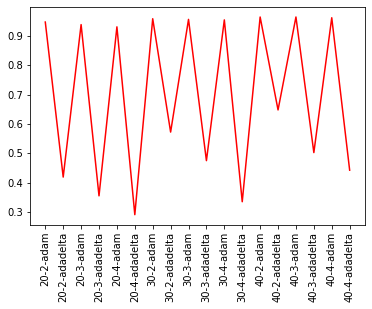

In [30]:
params = search_results.cv_results_['params']
dict_vals = [params[i].values() for i in range(len(params))]
name_list =[[str(v) for v in dv] for dv in dict_vals]
xlabels = ['-'.join(name_list[i]) for i in range(len(name_list))]

plt.plot(search_results.cv_results_['mean_test_score'], 'r')
plt.xticks(np.arange(len(xlabels)), xlabels, rotation='vertical')

plt.show()

Each of these innermost pairs slopes downwards, so we can say that
Adam consistently outperformed Adadelta.

The general trend in each second-level group is also downwards, so
adding more layers usually caused a loss of performance.

The general trend in the largest groups is going upwards, suggesting
that more neurons are better than fewer.

It’s interesting to note that the worst performance by far was the result
of 4 dense-dropout layers of 20 neurons each. So that’s a structure to
avoid for this data.

Keep in mind that we’re always referring to “layers” as our combination
of dense and dropout layers, using our default dropout rate of 0.2.

There’s no hard and fast rule for making these choices. We need to use
our judgment based on our knowledge of our model and data, coupled
with the results of our experiments, to guide our search strategy. If
we search with too fine a grid we can waste a lot of time, but if we use
too coarse a grid we could miss a big spike in performance. Generally
speaking, searching for performance is a task that rewards both intuition
and analysis.

In [34]:
from tensorflow.keras import backend

backend.clear_session()

param_grid2 = dict(model_step__number_of_layers=[1, 2], model_step__neurons_per_layer=[50, 80, 110, 170])

grid_searcher2 = GridSearchCV(estimator=pipeline, param_grid=param_grid2, verbose=2)
search_results2 = grid_searcher2.fit(X_train, original_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] model_step__neurons_per_layer=50, model_step__number_of_layers=1 
[CV]  model_step__neurons_per_layer=50, model_step__number_of_layers=1, total= 1.1min
[CV] model_step__neurons_per_layer=50, model_step__number_of_layers=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  model_step__neurons_per_layer=50, model_step__number_of_layers=1, total= 1.1min
[CV] model_step__neurons_per_layer=50, model_step__number_of_layers=1 
[CV]  model_step__neurons_per_layer=50, model_step__number_of_layers=1, total= 1.1min
[CV] model_step__neurons_per_layer=50, model_step__number_of_layers=2 
[CV]  model_step__neurons_per_layer=50, model_step__number_of_layers=2, total= 1.2min
[CV] model_step__neurons_per_layer=50, model_step__number_of_layers=2 
[CV]  model_step__neurons_per_layer=50, model_step__number_of_layers=2, total= 1.2min
[CV] model_step__neurons_per_layer=50, model_step__number_of_layers=2 
[CV]  model_step__neurons_per_layer=50, model_step__number_of_layers=2, total= 1.2min
[CV] model_step__neurons_per_layer=80, model_step__number_of_layers=1 
[CV]  model_step__neurons_per_layer=80, model_step__number_of_layers=1, total= 1.3min
[CV] model_step__neurons_per_layer=80, model_step__number_of_layers=1 
[CV]  model_step__neurons_per_layer=80, model_step__number

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 37.9min finished


In [35]:
best_index2 = np.argmax(search_results2.cv_results_['mean_test_score'])
print(f'best set of parameters:\n index {str(best_index2)}\n {str(search_results2.cv_results_["params"][best_index2])}\n′.')

best set of parameters:
 index 7
 {'model_step__neurons_per_layer': 170, 'model_step__number_of_layers': 2}
′.


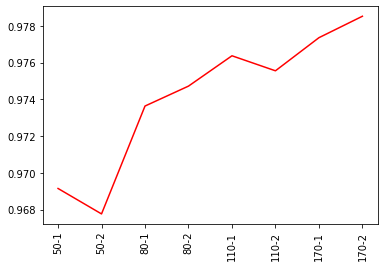

In [36]:
params2 = search_results2.cv_results_['params']
dict_vals = [params2[i].values() for i in range(len(params2))]
name_list =[[str(v) for v in dv] for dv in dict_vals]
xlabels = ['-'.join(name_list[i]) for i in range(len(name_list))]

plt.plot(search_results2.cv_results_['mean_test_score'], 'r')
plt.xticks(np.arange(len(xlabels)), xlabels, rotation='vertical')

plt.show()

Let’s crank up both the number of neurons and the search range quite
a bit.

In [37]:
backend.clear_session()

param_grid3 = dict(model_step__number_of_layers=[1, 2], model_step__neurons_per_layer=[180, 280, 380, 580])

grid_searcher3 = GridSearchCV(estimator=pipeline, param_grid=param_grid3, verbose=2)
search_results3 = grid_searcher3.fit(X_train, original_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] model_step__neurons_per_layer=180, model_step__number_of_layers=1 
[CV]  model_step__neurons_per_layer=180, model_step__number_of_layers=1, total= 1.8min
[CV] model_step__neurons_per_layer=180, model_step__number_of_layers=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  model_step__neurons_per_layer=180, model_step__number_of_layers=1, total= 1.9min
[CV] model_step__neurons_per_layer=180, model_step__number_of_layers=1 
[CV]  model_step__neurons_per_layer=180, model_step__number_of_layers=1, total= 1.9min
[CV] model_step__neurons_per_layer=180, model_step__number_of_layers=2 
[CV]  model_step__neurons_per_layer=180, model_step__number_of_layers=2, total= 2.5min
[CV] model_step__neurons_per_layer=180, model_step__number_of_layers=2 
[CV]  model_step__neurons_per_layer=180, model_step__number_of_layers=2, total= 2.5min
[CV] model_step__neurons_per_layer=180, model_step__number_of_layers=2 
[CV]  model_step__neurons_per_layer=180, model_step__number_of_layers=2, total= 2.5min
[CV] model_step__neurons_per_layer=280, model_step__number_of_layers=1 
[CV]  model_step__neurons_per_layer=280, model_step__number_of_layers=1, total= 2.5min
[CV] model_step__neurons_per_layer=280, model_step__number_of_layers=1 
[CV]  model_step__neurons_per_layer=280, model

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 93.8min finished


In [38]:
best_index3 = np.argmax(search_results3.cv_results_['mean_test_score'])
print(f'best set of parameters:\n index {str(best_index3)}\n {str(search_results3.cv_results_["params"][best_index3])}\n′.')

best set of parameters:
 index 5
 {'model_step__neurons_per_layer': 380, 'model_step__number_of_layers': 2}
′.


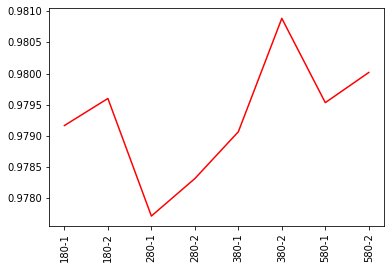

In [39]:
params3 = search_results3.cv_results_['params']
dict_vals = [params3[i].values() for i in range(len(params3))]
name_list =[[str(v) for v in dv] for dv in dict_vals]
xlabels = ['-'.join(name_list[i]) for i in range(len(name_list))]

plt.plot(search_results3.cv_results_['mean_test_score'], 'r')
plt.xticks(np.arange(len(xlabels)), xlabels, rotation='vertical')

plt.show()

We’ll stop searching here, but we could continue to try different values
for all of these parameters, or some we didn’t even try (like any
of the Normalization object’s parameters, or dropout_ratio in our
own model).

A good strategy is to start with searches that cover broad ranges with
just a few values. When we see where the model is performing best,
we can then run another, denser search to explore the area around
that zone. This is called multiresolution searching, and it’s just an
algorithmic version of what we do when we look for something in the
real world.

A useful alternative to the exhaustive search performed by the grid
searcher is provided by scikit-learn’s RandomizedSearchCV algorithm.